In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
import arviz as az
from scipy.stats import entropy

from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils
from agnfinder.tf_sampling import parameter_recovery, percentile_limits
from matplotlib import cm


In [3]:
os.chdir('/home/walml/repos/agnfinder')

In [4]:

# save_dir = 'results/emulated_sampling/real'
# save_dir = '/media/walml/beta/agnfinder_results/euclid_med_real_unc_fixed_z'
# save_dir = 'results/emulated_sampling/30k_burnin'
# save_dir = 'results/emulated_sampling/latest_100000_1_optimised'
# save_dir = 'results/emulated_sampling/latest_100000_64_optimised'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_50000_16_optimised'

# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_16_optimised_no_metric'
# save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_16_optimised_metric_by_chain'
save_dir = 'results/emulated_sampling/latest_hmc_1000_12800_32_optimised'
# save_dir = 'results/emulated_sampling/latest_hmc_200_2560_32_optimised_no_metric'
# save_dir = 'results/emulated_sampling/latest_hmc_200_2560_32_optimised'
assert os.path.isdir(save_dir)
all_galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')

# all_galaxy_locs = ['results/emulated_sampling/long_emcee/100k_samples_256_walkers_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/30k_burnin_70k_samples_256_walkers_ball_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/1k_burnin_50k_samples_256_walkers_ball_10x.h5']
# all_galaxy_locs = ['results/emulated_sampling/long_emcee/5k_burnin_100k_samples_256_walkers_ball_1x.h5']

# all_galaxy_locs = ['results/emulated_sampling/long_hmc/latest_hmc_3000_100000_64_optimised_x1.h5'] 
# all_galaxy_locs = ['results/emulated_sampling/long_hmc/latest_hmc_5000_300000_32_optimised_x1.h5'] 




assert all_galaxy_locs
print(len(all_galaxy_locs))

extra_thinning = 1

1


In [5]:
# open one galaxy for params
with h5py.File(all_galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']

marginal_bins = 50
dummy_array = np.zeros(42)  # anything
_, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=marginal_bins)
                
galaxies = []
true_observations = len(all_galaxy_locs)
# for n, galaxy_loc in enumerate(galaxy_locs[0:]):  # thinned
for n, galaxy_loc in enumerate(all_galaxy_locs):  # thinned
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
#         print(f['is_accepted'][...].mean())
#             if f['is_accepted'][...].mean() < 0.6:
#                 print(f['is_accepted'])
#             else:
                galaxy = {
#                     'free_param_names': f['free_param_names'],
                    'samples': np.squeeze(f['samples'][::extra_thinning]),
                    'name': galaxy_loc.split('_')[-3],
                    'chain': galaxy_loc.split('_')[-1].rstrip('.h5'),
                    'true_observations': np.squeeze(f['true_observations'][...]),
                    'true_params': np.squeeze(f['true_params'][...]),
                    'fixed_params': f['fixed_params'][...],
                    'uncertainty': f['uncertainty'][...],
                }
                
                galaxies.append(galaxy)
                
    except OSError:
        pass
    
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [6]:
galaxy['samples'].shape

(12800, 32, 8)

In [7]:
galaxy = galaxies[0]

In [8]:
# galaxy_locs = [x for x in all_galaxy_locs if 'galaxy__' in x]

In [9]:
# galaxy_locs

In [10]:
# n_chains = 256
# # n_chains = 64
# # n_chains = 1
# by_chain = np.reshape(galaxy['samples'], (-1, n_chains, 8))

In [11]:
# by_chain = np.stack([np.squeeze(g['samples']) for g in galaxies], axis=1)
# by_chain.shape

In [12]:
# by_chain.shape
by_chain_raw = galaxy['samples']

In [13]:
# from agnfinder.tf_sampling.hmc import get_covariances

In [14]:
# cov, inv = get_covariances(by_chain)

In [15]:
# cov_np = np.cov(by_chain[:, 0].transpose())
# diag_mask = np.eye(8, 8).astype(bool)
# cov_masked = cov_np.copy()
# cov_masked[diag_mask] = np.nan

In [16]:
# np.matmul(x-x.mean(), (y-y.mean()).transpose())/len(x)

In [17]:
# x = by_chain[:, 0, 0]
# y = by_chain[:, 0, 4]
# plt.scatter(x, y)

In [18]:
# def manual_covariance(x, y):
#     x_mu = x.mean()
#     y_mu = y.mean()
#     return np.mean((x - x_mu)*(y-y_mu))

In [19]:
# manual_covariance(x, y) / (x.std() * y.std())

In [20]:
# d = np.stack([x, y])
# print(d.shape)
# np.cov(d)

In [21]:
# sns.heatmap(cov_np)

In [22]:
# sns.heatmap(cov_masked)

In [23]:
# np.sqrt(cov[0])

In [24]:
# sns.heatmap(cov[0])

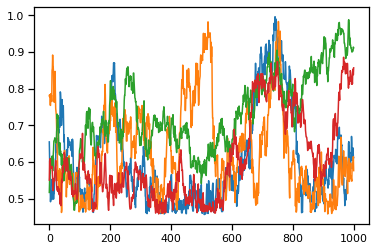

In [25]:
plt.plot(by_chain_raw[:1000, :4, 0])

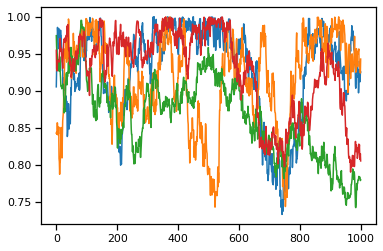

In [26]:
plt.plot(by_chain_raw[:1000, :4, 4])

In [27]:
def get_kl_vs_other_chains(chains, min_p=1e-5):
    n_chains = chains.shape[1]
    param_n = 0
    kl_divs = np.zeros(n_chains) * np.nan
    for chain_n in range(n_chains):
#     for chain_n in [1]:
        mask = np.ones(n_chains).astype(bool)
        mask[chain_n] = False
        this_chain = chains[:, chain_n]
#         other_chains = chains[:, mask]
        other_chains = chains
#         print(this_chain.shape, other_chains.shape)
        bins = np.linspace(0., 1., 10)
        other_probs, _ = np.histogram(other_chains[:, :, param_n], density=True, bins=bins)
        this_probs, _ = np.histogram(this_chain[:, param_n], density=True, bins=bins)
        allowed_probs = (other_probs > min_p) & (this_probs > min_p)
#         plt.plot(this_probs)
#         plt.plot(other_probs)
#         print(other_probs)
#         print(this_probs)
        kl_divs[chain_n] = entropy(other_probs[allowed_probs], this_probs[allowed_probs])  # calculates KL of q (second arg) approximating p (first arg)
    return kl_divs

In [28]:
kl_divs = get_kl_vs_other_chains(by_chain_raw)
print(kl_divs)

[0.00855466 0.00489844 0.00753328 0.0049434  0.01181117 1.07864169
 0.00416332 0.0025595  0.03547392 0.13845372 0.65646994 0.01714333
 0.04927829 0.1238587  0.00118916 0.01919517 0.00347232 0.01291942
 0.00750125 0.01113719 0.49643969 0.02545749 0.02764539 0.00346715
 0.12154712 0.00344112 0.00536094 0.01598346 0.07378111 0.03479745
 0.00999778 0.01336577]


(array([26.,  3.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([0.00118916, 0.10893441, 0.21667967, 0.32442492, 0.43217017,
        0.53991543, 0.64766068, 0.75540593, 0.86315119, 0.97089644,
        1.07864169]),
 <a list of 10 Patch objects>)

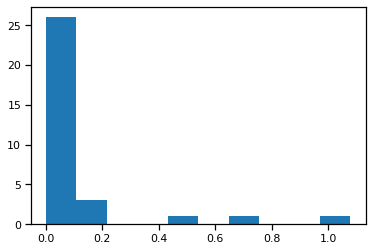

In [29]:
plt.hist(kl_divs)

In [30]:
worst_chain_n = np.argmax(kl_divs)


In [43]:
kl_divs = get_kl_vs_other_chains(by_chain_raw)
print(kl_divs)
chain_is_successful = kl_divs < (np.median(kl_divs) + kl_divs.std() * 2)
print(chain_is_successful)

[0.00855466 0.00489844 0.00753328 0.0049434  0.01181117 1.07864169
 0.00416332 0.0025595  0.03547392 0.13845372 0.65646994 0.01714333
 0.04927829 0.1238587  0.00118916 0.01919517 0.00347232 0.01291942
 0.00750125 0.01113719 0.49643969 0.02545749 0.02764539 0.00346715
 0.12154712 0.00344112 0.00536094 0.01598346 0.07378111 0.03479745
 0.00999778 0.01336577]
[ True  True  True  True  True False  True  True  True  True False  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True]


In [44]:
by_chain = by_chain_raw[:, chain_is_successful]

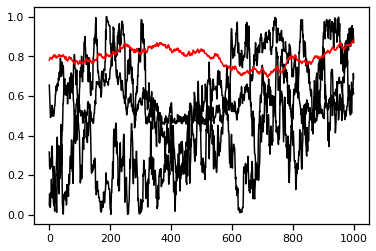

In [45]:
# plt.plot(by_chain_raw[:1000, chain_is_successful, 0].mean(axis=1), 'k--')
plt.plot(by_chain_raw[:1000, chain_is_successful, 0][:, 0], color='k')
plt.plot(by_chain_raw[:1000, chain_is_successful, 1][:, 0], color='k')
plt.plot(by_chain_raw[:1000, chain_is_successful, 2][:, 0], color='k')
plt.plot(by_chain_raw[:1000, ~chain_is_successful, 0][:, 0], color='r')

(array([88746., 78474., 58063., 43021., 34547., 26817., 18828., 12006.,
         7421.,  3277.]),
 array([0.45287523, 0.50758255, 0.56228983, 0.6169972 , 0.6717045 ,
        0.7264118 , 0.7811191 , 0.83582646, 0.89053375, 0.9452411 ,
        0.9999484 ], dtype=float32),
 <a list of 10 Patch objects>)

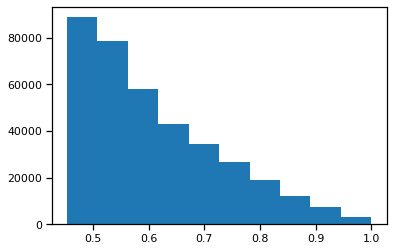

In [46]:
plt.hist(by_chain_raw[:, chain_is_successful, 0].flatten())

(array([11847.,  8487.,  4369.,  4005.,  2725.,  2175.,  2130.,  1464.,
         1002.,   196.]),
 array([0.45421833, 0.50740814, 0.56059796, 0.6137878 , 0.6669776 ,
        0.7201674 , 0.77335715, 0.82654697, 0.8797368 , 0.9329266 ,
        0.9861164 ], dtype=float32),
 <a list of 10 Patch objects>)

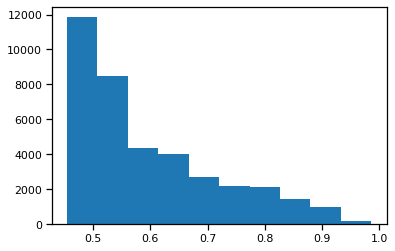

In [47]:
plt.hist(by_chain_raw[:, ~chain_is_successful, 0].flatten())

In [48]:
# from sklearn.metrics import adjusted_mutual_info_score

# adjusted_mutual_info_score(by_chain[:, 0, 0], by_chain[:, 4, 0])

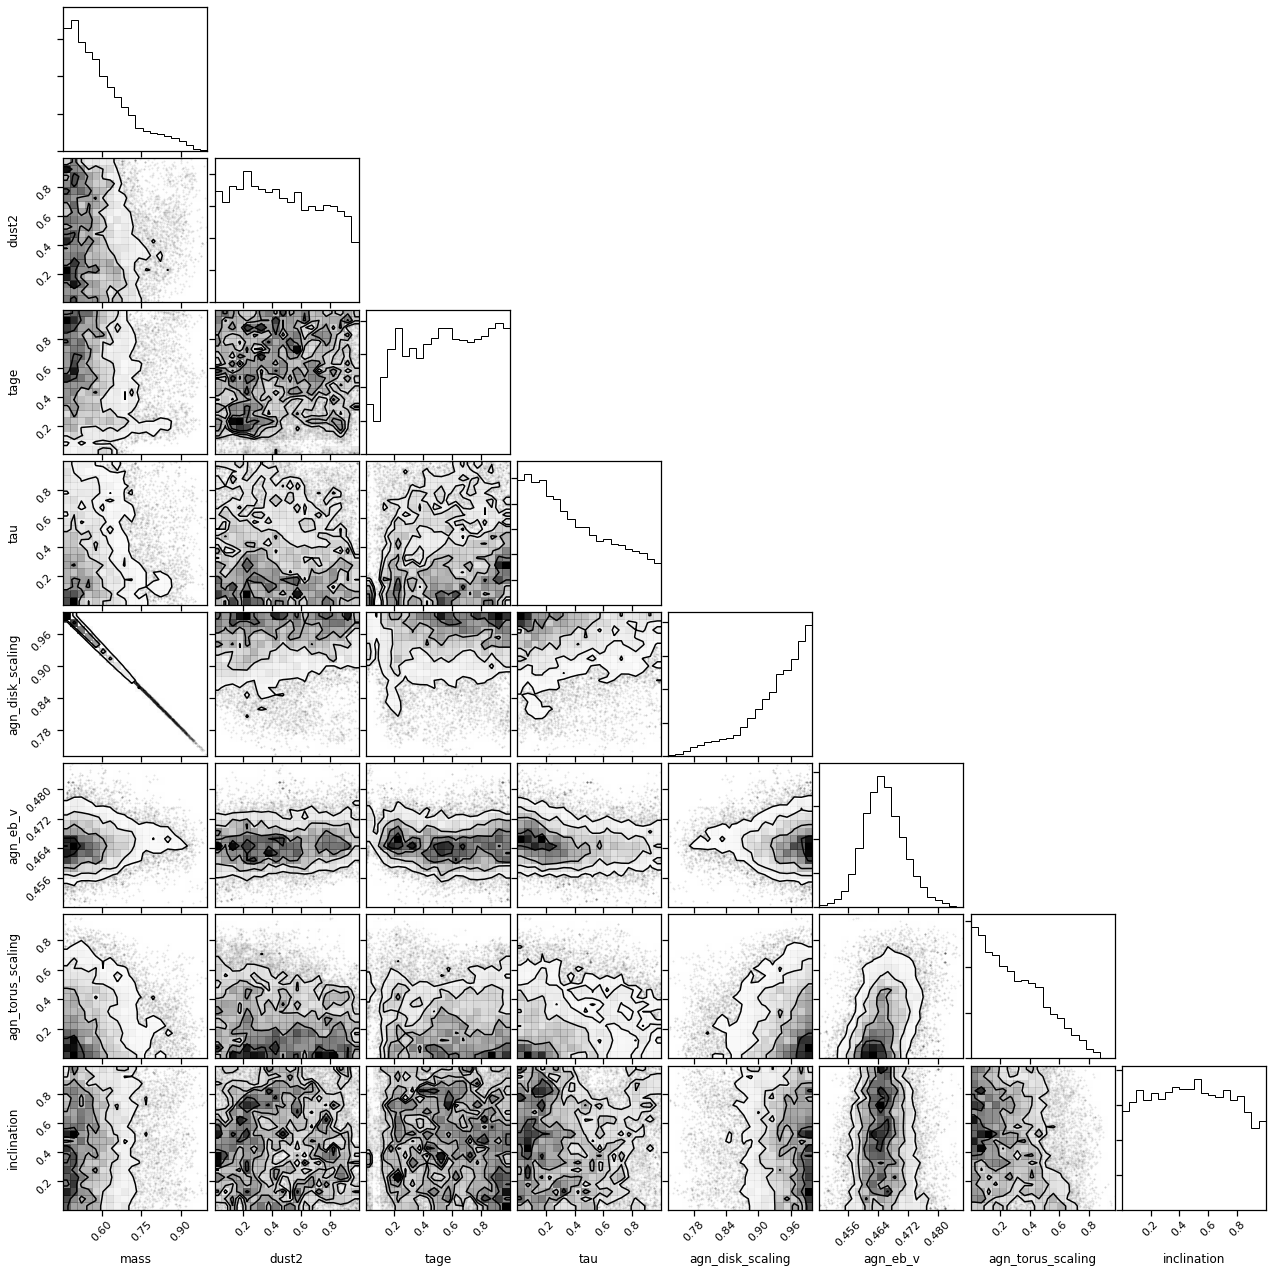

In [49]:
_ = corner.corner(by_chain_raw[:, 0, :], labels=params)

In [50]:
# _ = corner.corner(by_chain[:500].reshape(-1, 8), labels=params)  # early phase only

In [51]:
# _ = corner.corner(by_chain[-5000:].reshape(-1, 8), labels=params)  # late phase only

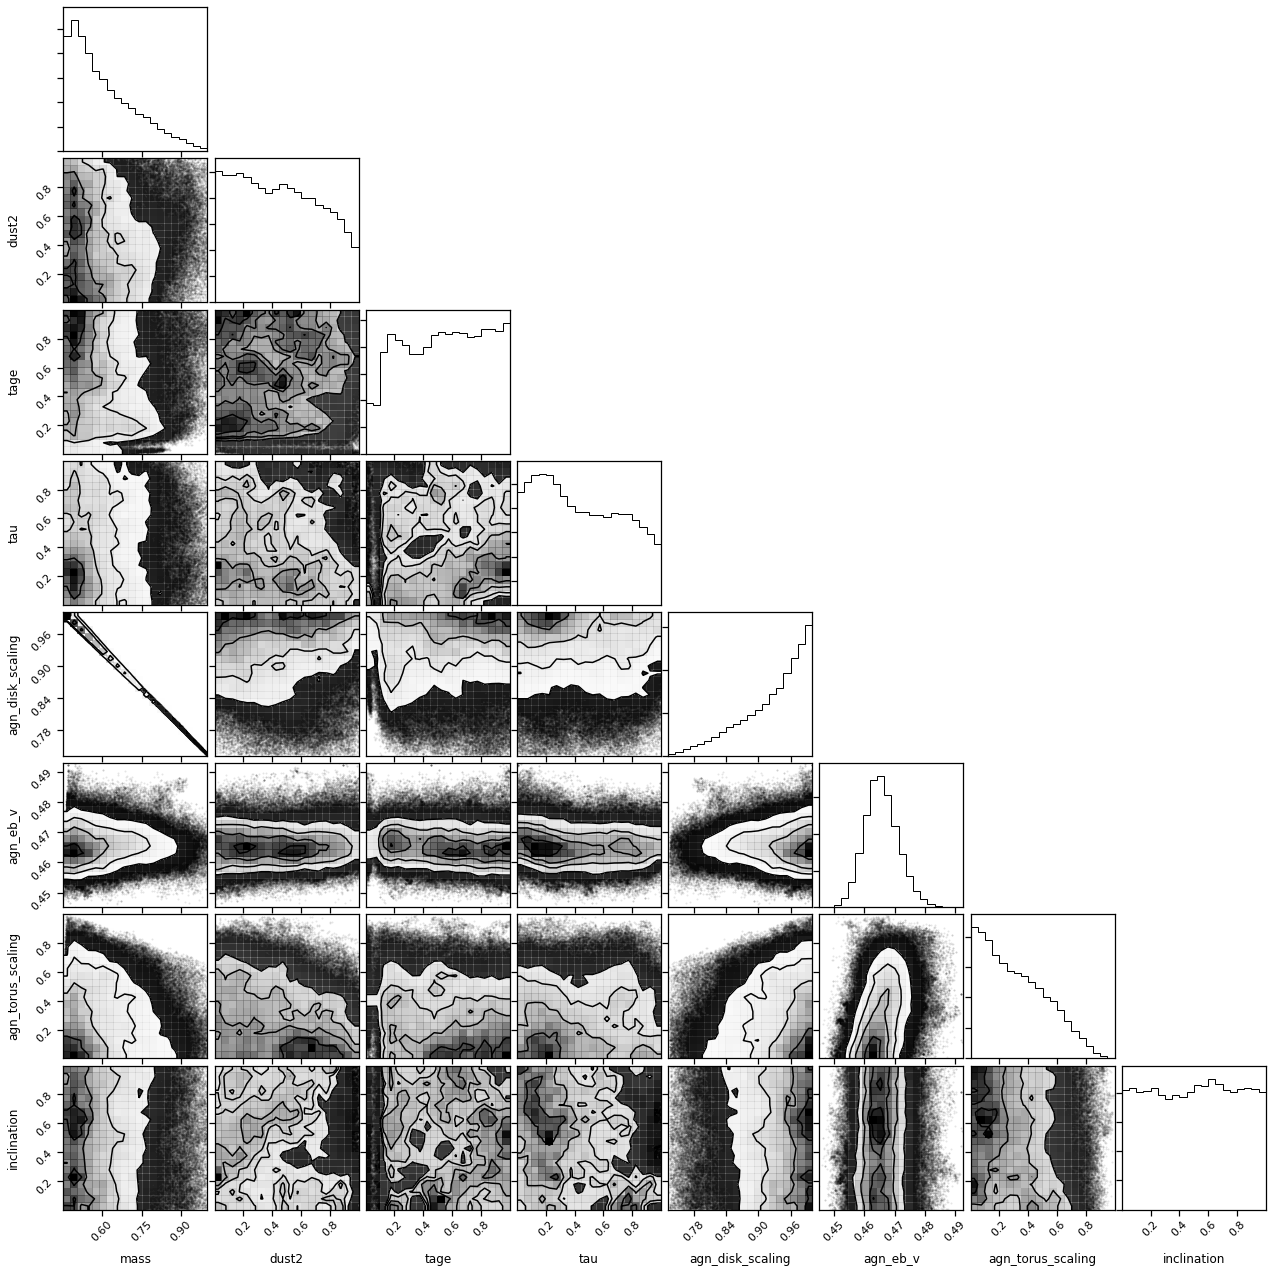

In [52]:
_ = corner.corner(by_chain_raw.reshape(-1, 8), labels=params)

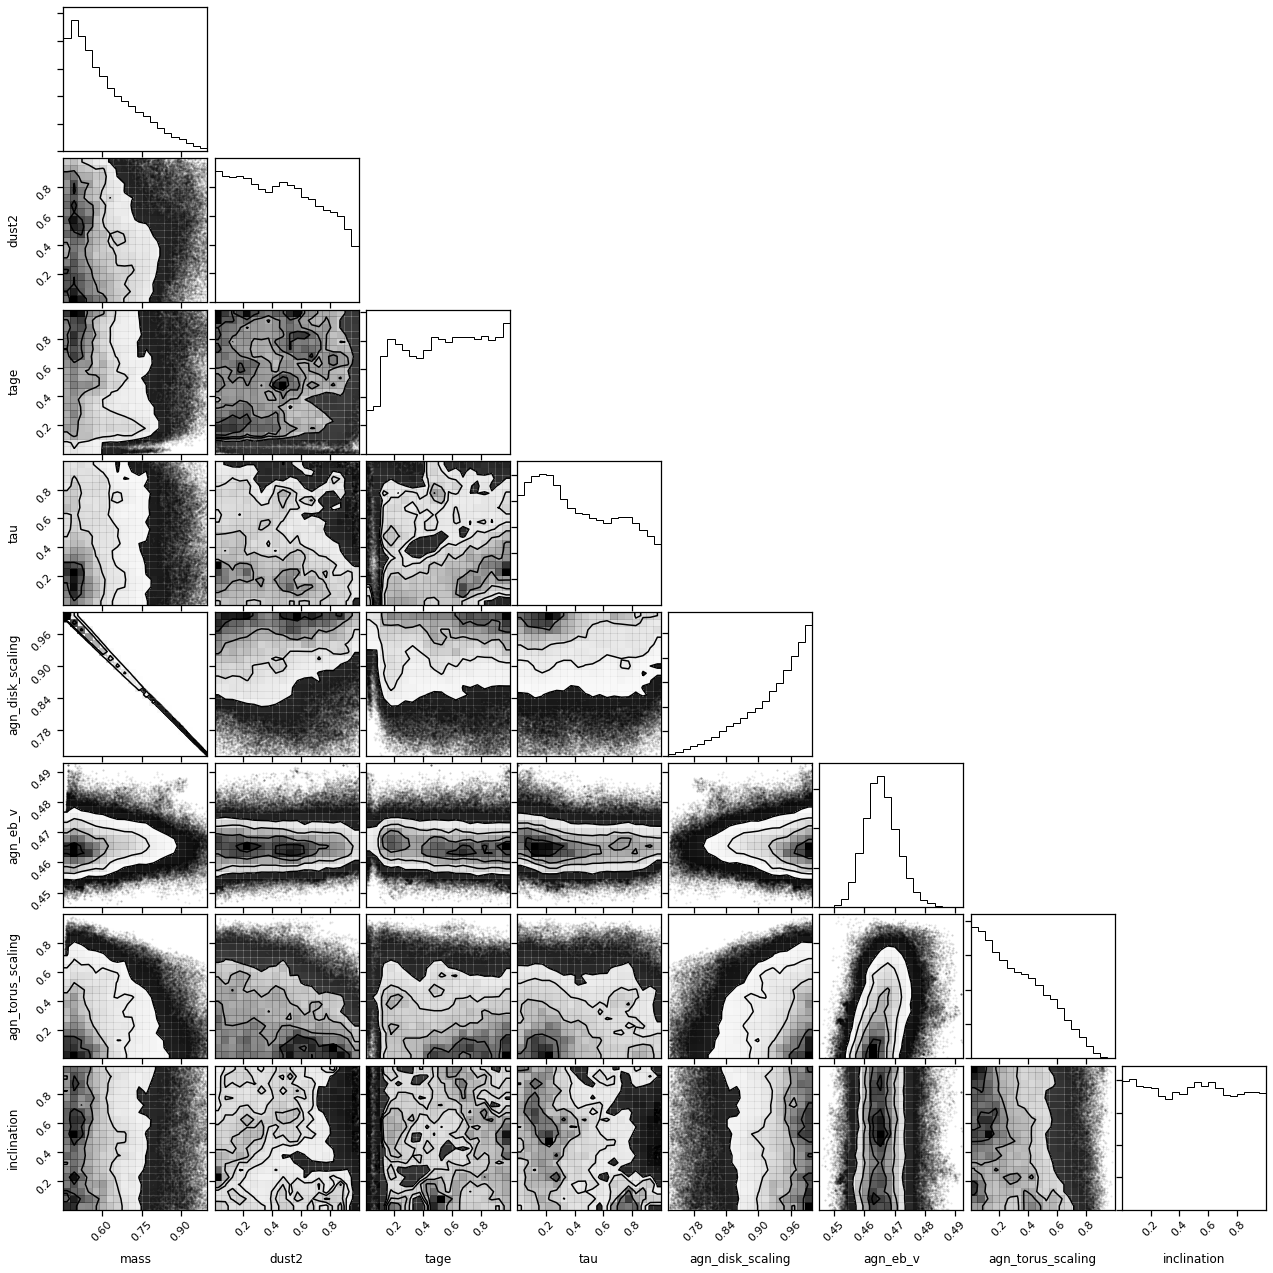

In [53]:
_ = corner.corner(by_chain.reshape(-1, 8), labels=params)

In [54]:
# _ = corner.corner(by_chain_not_bad[::10].reshape(-1, 8), labels=params)

## Marginals

### Marginals, cut by n-samples

In [55]:
def get_marginals(samples, marginal_bins=100, param_dim=8):
    dummy_array = np.zeros(42)  # anything
    _, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=marginal_bins)

    marginals = np.zeros((param_dim, marginal_bins))
    for param_n in range(param_dim):
        marginals[param_n], _ = np.histogram(samples[:, :, param_n].flatten(), density=True, bins=param_bins)  # galaxy samples is still dim3, confusingly

    return marginals, param_bins

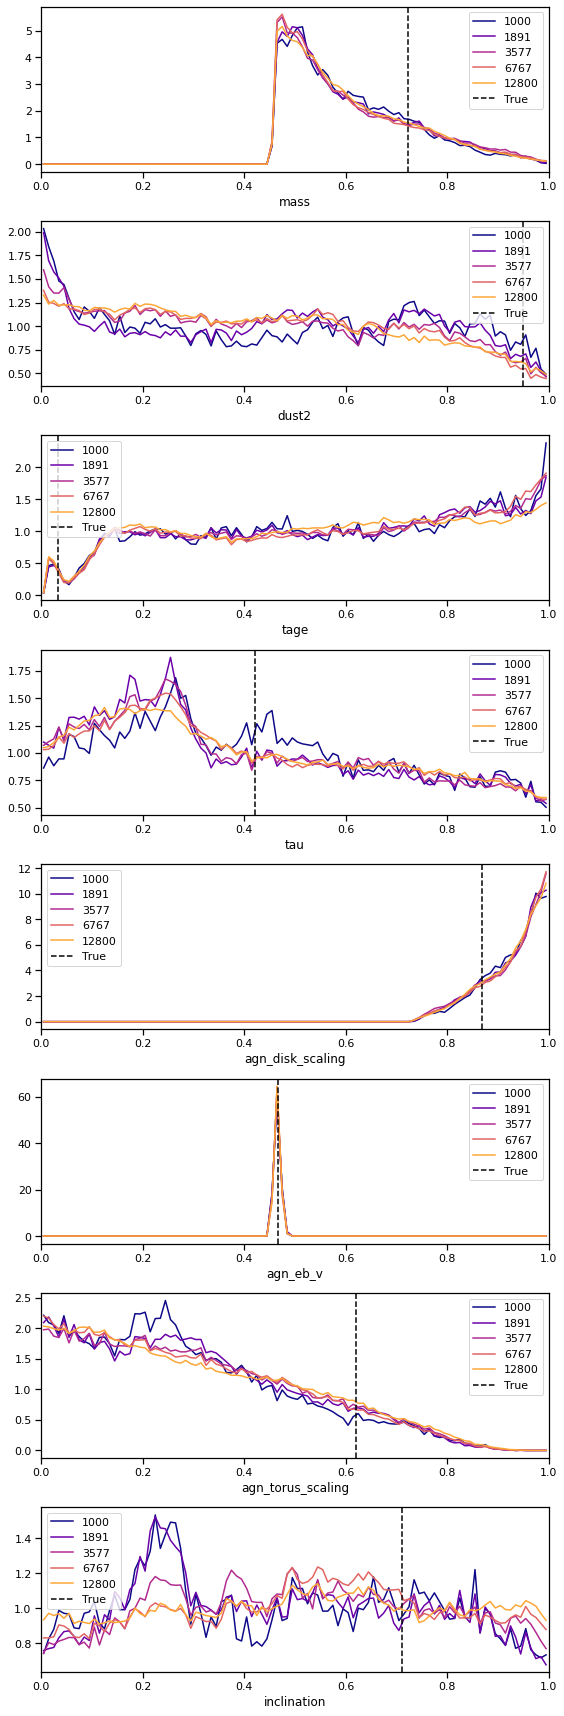

In [56]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

# limits = [
#     [0., 1.],
# #     [.5, .6],
#     [.1, .5],
#     [0., .2],
#     [0., 0.2],
#     [0., 0.7],
#     [0., 1.],
#     [0., 0.6],
#     [0., 1.]
# ]
limits = [[0., 1.] for _ in range(len(params))]

cuts = np.logspace(3, np.log10(len(by_chain)), num=5).astype(int)
# tau_est = np.array([16157.13877057, 48023.72647944, 52833.71572257, 35091.68658975,
#         4434.90811057,  2900.97728099,  5841.77996474,  2869.73666453]) / 10.

max_chains = 24

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(cuts):
        marginals, bins = get_marginals(by_chain[:cut, :max_chains, :], marginal_bins=100)
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=cut)
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()
    

### Marginals, cut by n-chains

Note that this is only relevant for HMC, as the performance by-chain for emcee is not defined - chains are dependent!

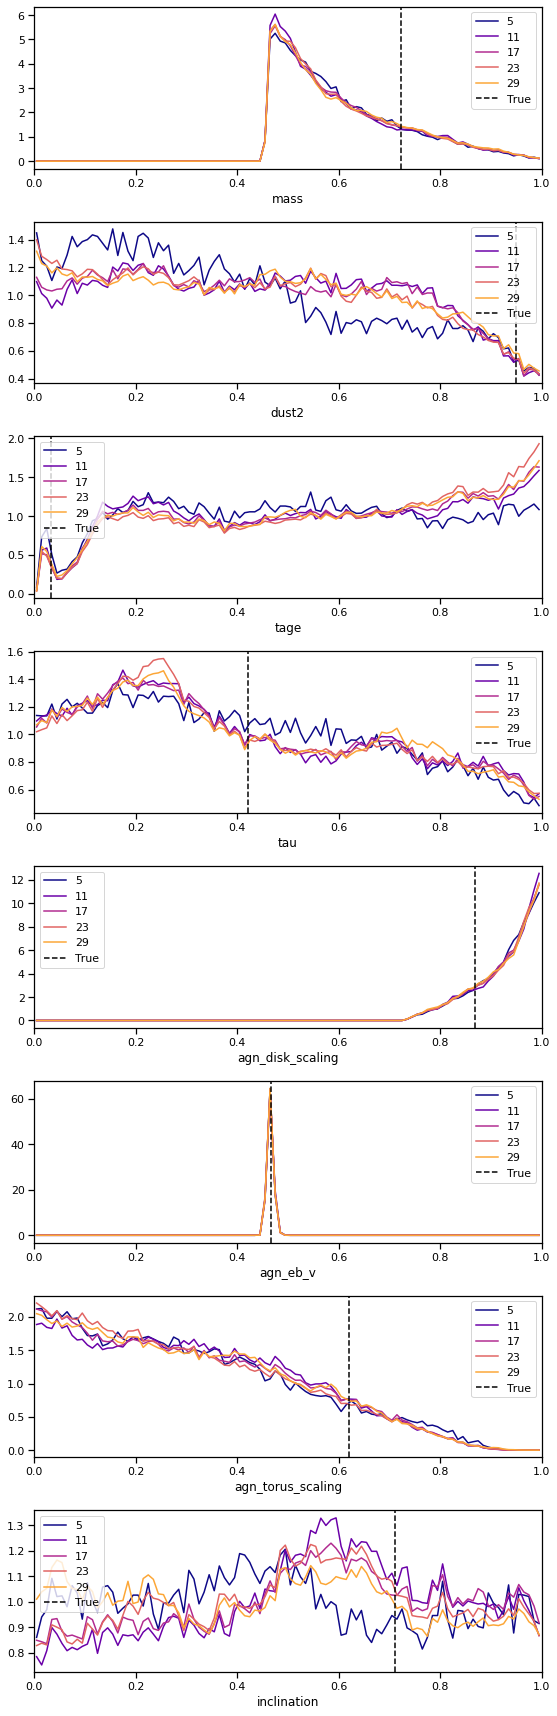

In [57]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

chains = np.linspace(5, by_chain.shape[1], num=5).astype(int)
max_samples = 7000

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(chains):
        marginals, bins = get_marginals(by_chain[:max_samples, :cut, :])
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=r'{}'.format(cut))
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()

## Identify bad chains, and remove them.

HMC only, as emcee chains are dependent.
For emcee, starting in a ball should prevent this anyway?

In [58]:
samples = galaxy['samples']
true_params = galaxy['true_params']

In [59]:
ds = az.convert_to_dataset(np.swapaxes(by_chain, 0, 1), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity
# ds_hmc = az.convert_to_dataset(np.swapaxes(by_chain_not_bad, 0, 1), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity

In [60]:
ds

<xarray.Dataset>
Dimensions:  (chain: 29, draw: 12800, x_dim_0: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26 27 28
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 12794 12795 12796 12797 12798 12799
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    x        (chain, draw, x_dim_0) float32 0.65457064 ... 0.89174795
Attributes:
    created_at:  2020-03-01T17:10:31.133183

In [61]:
# Trim the most extreme 5% percentiles?
mass_samples = by_chain[:, :, 0].flatten()
low, high = np.percentile(mass_samples, [2, 98])
print(low, high)
mass_samples_trimmed = mass_samples[(mass_samples > low) & (mass_samples < high)]

0.46291889429092403 0.9108902907371522


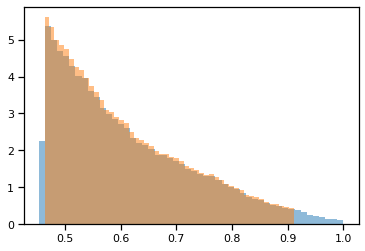

In [62]:
_ = plt.hist(mass_samples, bins=50, alpha=0.5, density=True)
_ = plt.hist(mass_samples_trimmed, bins=50, alpha=0.5, density=True)

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argume

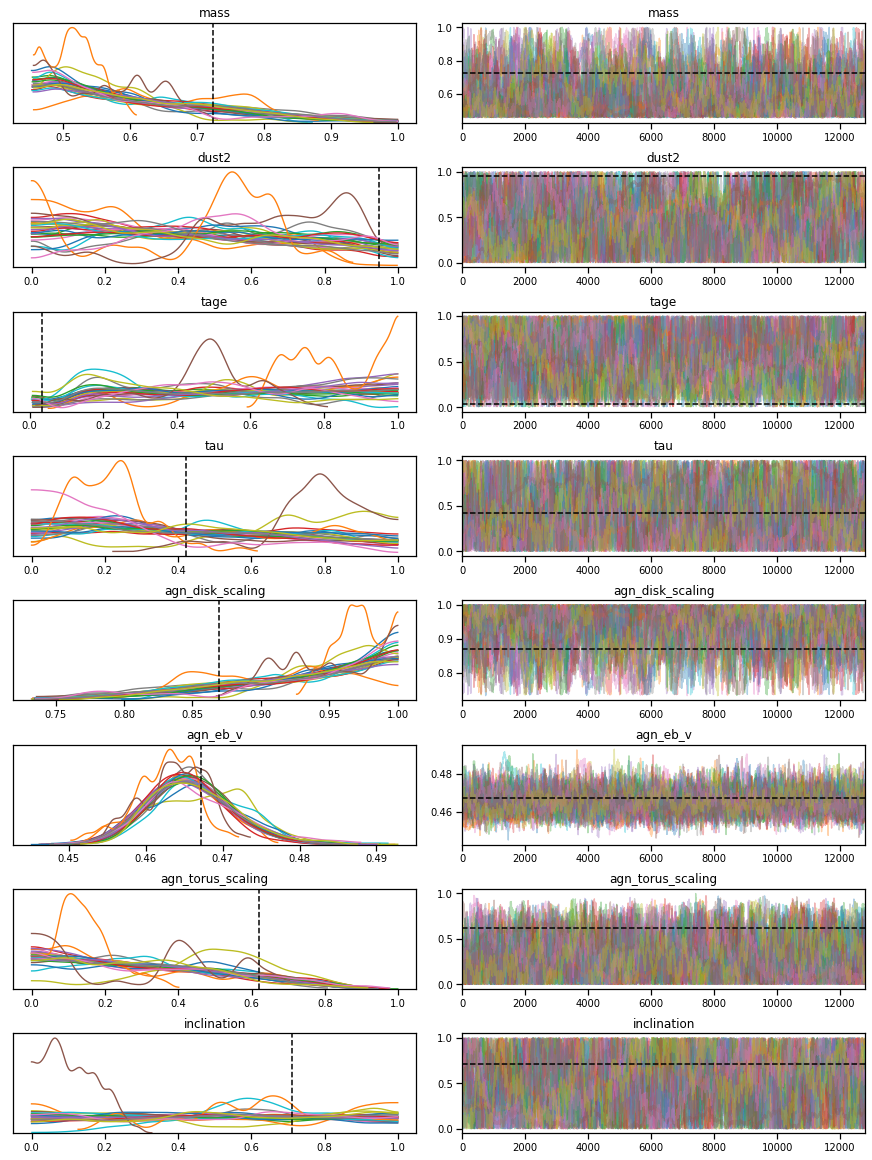

In [63]:
axes = az.plot_trace(ds)  
for param_n in range(len(true_params)):
    axes[param_n][0].set_title(params[param_n])
    axes[param_n][1].set_title(params[param_n])
    axes[param_n][0].axvline(true_params[param_n], linestyle='--', color='k')
    axes[param_n][1].axhline(true_params[param_n], linestyle='--', color='k')

In [64]:
std_devs = np.random.rand(*by_chain.shape[1:])
observation_ids = [np.random.choice(['a', 'b', 'c']) for _ in range(by_chain.shape[1])]
std_devs_df = pd.DataFrame(data=std_devs, index=observation_ids).reset_index()  # columns are params (int range)
std_devs_by_galaxy = std_devs_df.groupby('index').agg('mean')
# for obs_id in self.observation_ids:

In [65]:
std_devs_by_galaxy

0         1         2         3         4         5         6  \
index                                                                         
a      0.515094  0.641321  0.481817  0.498276  0.546208  0.422198  0.526022   
b      0.502110  0.430991  0.489788  0.500364  0.452152  0.436283  0.416260   
c      0.506378  0.509433  0.527494  0.543741  0.497692  0.488867  0.688130   

              7  
index            
a      0.507131  
b      0.548179  
c      0.567724

In [66]:
dict(zip(std_devs_by_galaxy.index, std_devs_by_galaxy.values))

{'a': array([0.51509441, 0.6413213 , 0.48181654, 0.4982764 , 0.54620827,
        0.42219823, 0.52602181, 0.50713069]),
 'b': array([0.5021098 , 0.43099086, 0.48978821, 0.50036442, 0.45215195,
        0.43628324, 0.41626049, 0.54817869]),
 'c': array([0.50637843, 0.50943337, 0.52749399, 0.5437409 , 0.49769226,
        0.48886681, 0.68812976, 0.56772449])}

In [67]:
std_devs_df.head()

index         0         1         2         3         4         5         6  \
0     c  0.041304  0.890600  0.530721  0.169871  0.074251  0.277150  0.430046   
1     c  0.073797  0.294477  0.699400  0.397681  0.564694  0.173496  0.818939   
2     b  0.779318  0.723215  0.109808  0.587982  0.777865  0.692663  0.507124   
3     b  0.987909  0.142880  0.769113  0.998303  0.027685  0.018551  0.031741   
4     b  0.159836  0.265229  0.920446  0.784182  0.613551  0.224597  0.678649   

          7  
0  0.097109  
1  0.767994  
2  0.976399  
3  0.098328  
4  0.564226

In [68]:
np.argmax(np.median(by_chain[:, :, 0], axis=0))

11

In [69]:
from agnfinder.tf_sampling import deep_emulator

In [70]:
import tensorflow as tf

In [71]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 
       10205.12640526])

In [72]:
checkpoint_dir = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_dir, new=False)

In [73]:
fixed_params = galaxy['fixed_params'].reshape(1, -1)
fixed_params

array([[0.44265592]], dtype=float32)

In [74]:
def get_expected_photometry(x):
    x_with_fixed_params = tf.concat([fixed_params, x], axis=1)
    return deep_emulator.denormalise_photometry(emulator(x_with_fixed_params, training=False)).numpy()

In [75]:
x = np.random.rand(8).reshape(1, -1)

In [76]:
fixed_params.shape, x.shape

((1, 1), (1, 8))

In [77]:
np.concatenate([fixed_params, x], axis=1)

array([[0.44265592, 0.51969885, 0.91372317, 0.83830242, 0.24782734,
        0.23951689, 0.39498362, 0.7627277 , 0.13429692]])

In [78]:
get_expected_photometry(x)

array([[2.5456847e-13, 8.8037910e-13, 2.7752867e-12, 6.5199786e-12,
        1.4342498e-11, 2.2367280e-10, 6.6049569e-11, 2.6002450e-11]],
      dtype=float32)

In [79]:
true_params

array([0.72361314, 0.9489169 , 0.03382206, 0.42199516, 0.86924887,
       0.4671447 , 0.61968666, 0.712116  ], dtype=float32)

IndexError: index 29 is out of bounds for axis 1 with size 29

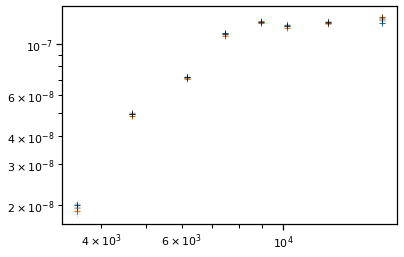

In [80]:
plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='true')
plt.loglog(wavelengths, get_expected_photometry(true_params.reshape(1, -1))[0], linestyle='', marker='+', label='true params')
# plt.loglog(wavelengths, get_expected_photometry(np.median(by_chain, axis=[0, 1]).reshape(1, -1))[0], linestyle='', marker='+', label=)
for n in range(50):
    plt.loglog(wavelengths, get_expected_photometry(by_chain[0, n, :].reshape(1, -1))[0], linestyle='', marker='+', color='k', alpha=0.05)
plt.legend()

In [ ]:
get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))[0]

In [ ]:
plt.loglog(wavelengths, galaxy['true_observations'], linestyle='', marker='+', label='true', color='k')
plt.loglog(wavelengths, get_expected_photometry(by_chain[0, 0, :].reshape(1, -1))[0], linestyle='', marker='+')
plt.loglog(wavelengths, get_expected_photometry(by_chain[0, 34, :].reshape(1, -1))[0], linestyle='', marker='+', color='r')

In [ ]:
by_chain_not_bad = np.concatenate([by_chain[:, :34], by_chain[:, 35:]], axis=1)
by_chain_not_bad.shape

In [ ]:
fig, axes = plt.subplots(nrows=len(params), figsize=(8, 24))

chains = np.linspace(1, 51, num=5).astype(int)

for param_n, p in enumerate(params):
    ax = axes[param_n]
    for n, cut in enumerate(chains):
        marginals, bins = get_marginals(by_chain_not_bad[:, :cut, :])
        bin_centers = bins[:-1] + (bins[1:] - bins[:-1]) / 2
        ax.plot(bin_centers, marginals[param_n], color=cm.plasma(float(n)/len(cuts)), label=r'{}'.format(cut))
    ax.axvline(galaxy['true_params'][param_n], color='k', linestyle='--', label='True')
#     ax.set_ylim(0, 4)
    ax.set_xlim(*limits[param_n])
    ax.legend()
    ax.set_xlabel(p)
fig.tight_layout()

In [ ]:
from emcee.autocorr import integrated_time

In [ ]:
# emcee is happy with time, walkers, dimensions
tau_est = integrated_time(by_chain, quiet=True)
tau_est

In [ ]:
# array([ 628.51810087,  656.14108053,  858.91637139,  925.08219734,
#        1049.84372125, 3584.59257398, 1421.13224327, 3356.72261827])

# hmc

In [ ]:
# # emcee is happy with time, walkers, dimensions
# tau_est_not_bad = integrated_time(by_chain_not_bad, quiet=True)
# tau_est_not_bad

In [ ]:
sns.barplot(y=params, x=tau_est)  # estimate tau using all chains

In [ ]:
# extinction and inclination are the most uncertain, both almost totally unknown

In [ ]:
sns.barplot(y=params, x=len(by_chain)/tau_est)  # effective samples per chain

In [ ]:
# hmc, no thinning, 1 chain (probably not a good estimate?):

# array([4594.71930395, 4106.71578812, 3291.08818621, 4068.70526458,
#        2642.20579738, 6012.44976159, 5008.85703236, 5370.88693979])

In [ ]:
# 100k samples, 30k burnin, no thinning, 256 walkers, emcee:
    
# array([4747.67220695, 4897.18058522, 5929.65856414, 5970.30192595,
#        4055.12796419, 2566.78810495, 3377.97829428, 2423.96171419])

# (too short for reliable estimate)

In [ ]:
tau_est * 10  # in real samples, prop.compute time

In [ ]:
# 100k samples, 30k burnin, 10x thinning, 256 walkers, emcee:
    
# array([16157.13877057, 48023.72647944, 52833.71572257, 35091.68658975,
#         4434.90811057,  2900.97728099,  5841.77996474,  2869.73666453])



In [ ]:
# 100k samples HMC, 10k burnin, 10x thinning, 64 walkers, hmc:
    
# array([ 6285.1810087 ,  6561.41080526,  8589.1637139 ,  9250.82197341,
#        10498.43721253, 35845.92573981, 14211.32243268, 33567.22618269])

In [ ]:
geweke = az.geweke(np.swapaxes(galaxy['samples'], 0, 1))
geweke.shape
# plt.plot(geweke[:, 1])

In [ ]:
geweke

In [ ]:
plt.plot(geweke[:, 0])

In [ ]:
rhat = az.rhat(ds)
rhat_values = rhat.x.values
print('Not valid for emcee! walkers are correlated')
print('Values greater than one indicate that one or more chains have not yet converged.')
for n, p in enumerate(params):
    print(p, '{:.2f}'.format(rhat_values[n]))

In [ ]:
# may not be valid for walkers?

In [ ]:
_ = az.plot_autocorr(ds, max_lag=5000, combined=True)  # in thinned units

In [ ]:
_ = az.plot_autocorr(ds, max_lag=5000)  # in thinned units

In [ ]:
_ = az.plot_mcse(ds)

In [ ]:
ds_hmc

In [ ]:
ess = az.ess(ds_hmc)

In [ ]:
ess.x.values

In [ ]:
sns.barplot(y=params, x=ess.x.values)

In [ ]:
# Plot local ESS. This plot, together with the quantile ESS plot, is recommended to check that there are enough samples for all the explored regions of parameter space.
_ = az.plot_ess(ds, kind="local")

In [ ]:
_ = az.plot_ess(ds, kind="quantile")

In [ ]:
# Plot ESS evolution as the number of samples increase. When the model is converging properly, both lines in this plot should be roughly linear.
_ = az.plot_ess(ds, kind="evolution")

In [ ]:
# https://github.com/dfm/emcee/blob/b9d6e3e7b1926009baa5bf422ae738d1b06a848a/src/emcee/backends/backend.py#L130
# https://github.com/dfm/emcee/blob/b9d6e3e7b1926009baa5bf422ae738d1b06a848a/src/emcee/autocorr.py#L47